## KERAS LSTM + MLP 

In this notebook we aim to create an MLP neural network and a LSTM Neural Network using the Keras Sequential Model. We will use the Stock KME to perform our analysis. 

In [27]:
import math

In [48]:
import sqlite3
import glob
import pandas as pd
%matplotlib inline
import seaborn as sns
from helpers_funcs.sql_funcs import fetch_mquote
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Grabbing data from the SQLite Database. 
datas_conn = sqlite3.connect('stocks_data.db')
datas_c = datas_conn.cursor()
datas_c.execute("SELECT name FROM sqlite_master WHERE type='table';")
current_list = (datas_c.fetchall())

In [180]:
def dates_df_fromdf(symbol_df):
    #Generates a Series of the dates and timestamps which correspond to
    # Midquote values.
    dates= pd.Series(symbol_df['DATE'])
    dates = pd.to_timedelta(dates, unit='D') + pd.Timestamp('1960-1-1')
    for x in range(len(dates)):
        dates[x]=pd.Timestamp(str(dates[x])[:11]+(symbol_df['itime'][x]))
        
    return dates


In [181]:
def dates_df_fromdf_2(symbol_df):
    #Generates a Series of the dates and timestamps which correspond to
    # Midquote values.
    dates= pd.Series(symbol_df['DATE'])
    dates = pd.to_timedelta(dates, unit='D') + pd.Timestamp('1960-1-1')
    for x in range(len(dates)):
        dates[x]=pd.Timestamp(str(dates[x])[:11])
        
    return dates

In [183]:
dates_without_times=dates_df_fromdf_2(df_KME)

In [6]:
df_KME = pd.read_sql_query('select * from "{}"'.format('KME'), datas_conn)
#Generate a df for stock data

In [8]:
df_KME.head(n=5)

,PERMNO,SYMBOL,DATE,itime,mquote
0,88486.0,KME,14843.0,09:30:00,5.59375
1,88486.0,KME,14843.0,09:31:00,5.59375
2,88486.0,KME,14843.0,09:32:00,5.59375
3,88486.0,KME,14843.0,09:33:00,5.59375
4,88486.0,KME,14843.0,09:34:00,5.59375


In [15]:
KME_dates = dates_df_fromdf(df_KME)

df_KME['mquote']=pd.to_numeric(df_KME['mquote'])

df_KME['DATE']=pd.to_numeric(df_KME['DATE'])

#Modification to take care of graphing error. 

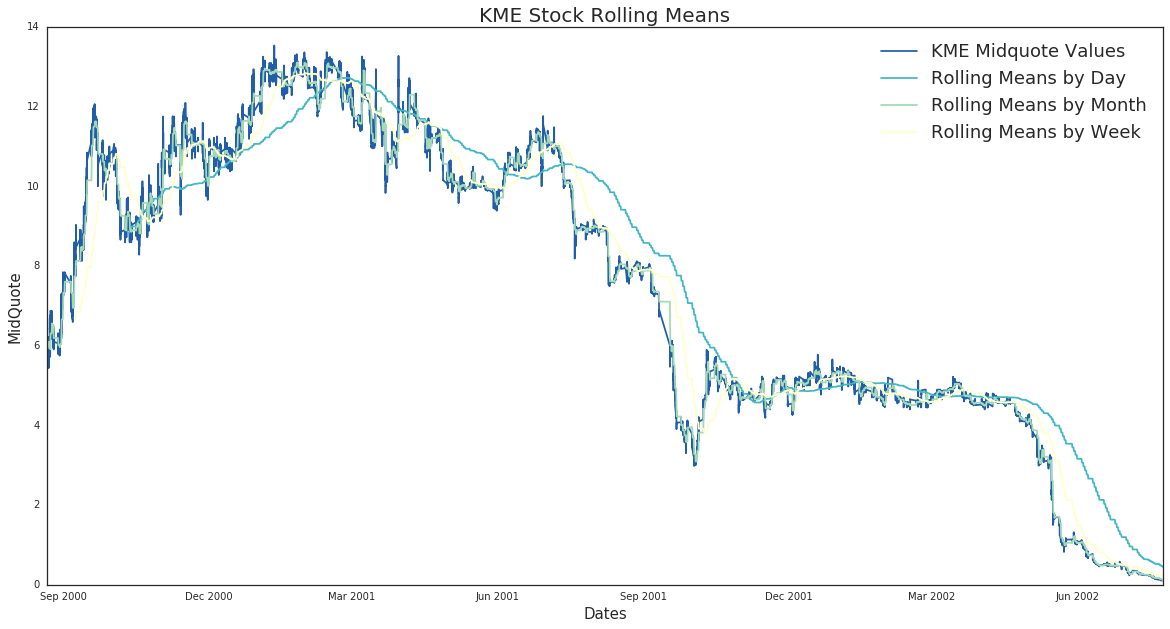

In [247]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("white")
ax.plot(KME_dates,pd.to_numeric(df_KME['mquote']),color='#225ea8',label='KME Midquote Values')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=14467).mean().values,color='#41b6c4',label='Rolling Means by Day')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=481).mean().values,color='#a1dab4',label='Rolling Means by Month')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=5083).mean().values,color='#ffffcc',label='Rolling Means by Week')

ax.set_title('KME Stock Rolling Means',size = 20)
ax.set_xlabel('Dates',size=15)
ax.set_ylabel('MidQuote',size=15)
ax.legend(prop={'size':18})

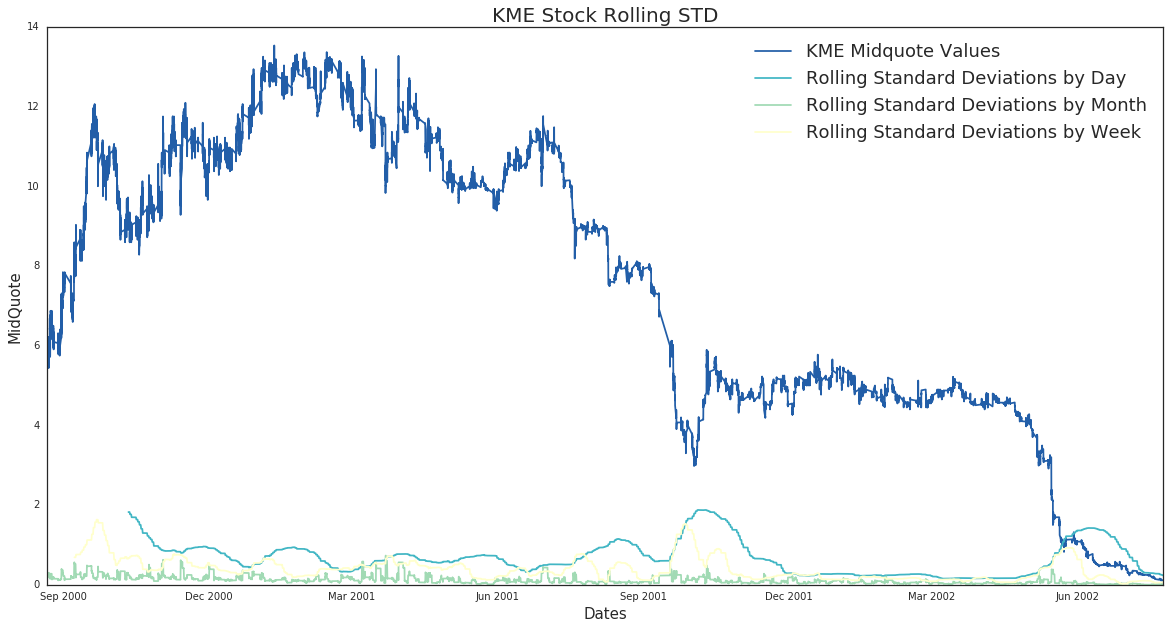

In [248]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(KME_dates,pd.to_numeric(df_KME['mquote']),color='#225ea8',label='KME Midquote Values')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=14467).std().values,color='#41b6c4',label='Rolling Standard Deviations by Day')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=481).std().values,color='#a1dab4',label='Rolling Standard Deviations by Month')
ax.plot(KME_dates,df_KME['mquote'].rolling(center=False,window=5083).std().values,color='#ffffcc',label='Rolling Standard Deviations by Week')

ax.set_title('KME Stock Rolling STD',size = 20)
ax.set_xlabel('Dates',size=15)
ax.set_ylabel('MidQuote',size=15)
ax.legend(prop={'size':18})

Finding the rolling means by Day, Week and Month to observe specific tredns in the data given over specific time intervals. Useful to observe whether the general trend of the stock in the market is increasing or deacreasing. 

Rolling STD lets us the variation of the values over the two years.  

## Keras MLP

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.recurrent import LSTM


Using Theano backend.


In [46]:
#Function to seperate data set into training and testing
#The set value for look back in time is 5 minutes
#Function Parameters: stock_data values and look_back: time to look back
def create_training_set(stock_data, look_back=5):
    dataX, dataY = [], []
    for i in range(len(stock_data)-look_back-1):
        temp_val = stock_data[i:(i+look_back)]
        dataX.append(temp_val)
        dataY.append(stock_data[i + look_back])
    return np.array(dataX), np.array(dataY)
 

In [377]:
def graphing_wrapper(dates,len_test,len_train,train,test,data_df,title_test,title_train):
    fig_MLP, ax_MLP = plt.subplots(figsize=(20,10))
    ax_MLP.plot(data_df['mquote'].values[0:(train_size)],color='#225ea8',label='KME Midquote Values')
    ax_MLP.plot(train,alpha=0.6,color='#a1dab4',label='Train Prediction')
    ax_MLP.set_title(title_test,size=20)
    ax_MLP.set_xlabel('Dates')
    ax_MLP.set_ylabel('MidQuote')
    ax_MLP.legend(prop={'size':18})

    ax_MLP.set_xticklabels(['Sep 2000','Nov 2000','Jan 2001','Mar 2001','May 2001','Jul 2001','Sep 2001','Nov 2001'])
    fig_MLP2, ax_MLP2 = plt.subplots(figsize=(20,10))
    ax_MLP2.plot(data_df['mquote'].values[-(test_size):],color='#225ea8',label='KME Midquote Values')
    ax_MLP2.plot(test,color='#41b6c4',alpha=0.6,label='Test Prediction')
    ax_MLP2.set_xticklabels(['Dec 2001','Jan 2002','Feb 2002','Mar 2002','Apr 2002','May 2002','Jun 2002','Jul 2002'])
    ax_MLP2.set_title(title_train,size=20)
    ax_MLP2.set_xlabel('Dates')
    ax_MLP2.set_ylabel('MidQuote')
    ax_MLP2.legend(prop={'size':18})
    
    xrand = np.linspace(0,10000,len(data_df['mquote'].values))

    fig_MLP3, ax_MLP3 = plt.subplots(figsize=(20,10))
    ax_MLP3.plot(xrand,data_df['mquote'].values,color='#225ea8',label='KME Midquote Values')
    ax_MLP3.plot(xrand[0:train_size],np.concatenate((train,test))[0:(train_size)],alpha=0.6,color='#a1dab4',label='Train Prediction')
    #ax_MLP3.plot(data_df['mquote'].values[-(test_size):],color='#225ea8',label='KME Midquote Values')
    ax_MLP3.plot(xrand[-test_size:],np.concatenate((train,test))[-(test_size):],color='#41b6c4',alpha=0.6,label='Test Prediction')
    ax_MLP3.set_title('KME Training and Test Prediction from Multilayer Perceptron',size=20)
    ax_MLP3.set_xlabel('Dates')
    ax_MLP3.set_ylabel('MidQuote')
    ax_MLP3.legend(prop={'size':18})
    ax_MLP3.set_xticklabels(['Sep 2000','Dec 2000','Mar 2001','Jun 2001','Sep 2001','Dec 2001','Mar 2002','Jun 2002'])

    
     
    fig_MLP4, ax_MLP4 = plt.subplots(figsize=(20,10))
    ax_MLP4.plot(np.diff(data_df['mquote'].values[0:train_size],n=50),color='#225ea8',label='KME Midquote Values')
    ax_MLP4.plot(np.diff(train,n=50),color='#a1dab4',label='Train Prediction')
    ax_MLP4.set_xticklabels(['Sep 2000','Nov 2000','Jan 2001','Mar 2001','May 2001','Jul 2001','Sep 2001','Nov 2001'])
    ax_MLP4.set_title('Percentage Change in Train Prediction ')
    ax_MLP4.set_xlabel('Dates')
    ax_MLP4.legend(prop={'size':18})
    train_mse = mean_squared_error(data_df['mquote'].values[0:len(train)],train)
    print("Mean Squared Error of Training = ", train_mse)
    
    
    fig_MLP5, ax_MLP5 = plt.subplots(figsize=(20,10))
    ax_MLP5.plot(np.diff(data_df['mquote'].values[-len(test_MLP_predict):],n=50),color='#225ea8',label='KME Midquote Values')
    ax_MLP5.plot(np.diff(test,n=50),color='#41b6c4',label='Test Prediction')
    ax_MLP5.set_xticklabels(['Dec 2001','Jan 2002','Feb 2002','Mar 2002','Apr 2002','May 2002','Jun 2002','Jul 2002'])
    ax_MLP5.set_title('Percentage Change in Test Prediction ')
    ax_MLP5.set_xlabel('Dates')
    ax_MLP5.legend(prop={'size':18})
    test_mse = mean_squared_error(data_df['mquote'].values[-len(test):],test)
    print("Mean Squared Error of Test = ", test_mse) 


In [366]:
def consolidate_learning(initial_neurons,hidden_layers,train_percent,test_percent,data_df,look_back,title_train,title_test):
    train_size=math.floor(len(data_df['mquote'].values)*train_percent)
    test_size = len(data_df['mquote'].values)-train_size
    train_values = data_df['mquote'].values[0:train_size]
    test_values = data_df['mquote'].values[train_size:train_size+test_size]
    train_X,train_Y = create_training_set(train_values,look_back=look_back)
    test_X,test_Y = create_training_set(test_values,look_back=look_back)
    model_MLP= Sequential()
    model_MLP.add(Dense(initial_neurons, input_dim=look_back, activation='relu'))
    for x in range(hidden_layers):
        if(hidden_layers==0):
            pass
        num =1
        if(math.floor(hidden_layers/2)==0):
            num =1
        else:
            num = math.floor(hidden_layers/2)
            
        model_MLP.add(Dense(initial_neurons/num,activation='relu'))
        initial_neurons = initial_neurons/hidden_layers
    model_MLP.add(Dense(1))
    model_MLP.compile(loss='mean_squared_error', optimizer='adam')
    model_MLP.fit(train_X, train_Y, nb_epoch=20, batch_size=5, verbose=2)
    train_evaluation  = model_MLP.evaluate(train_X,train_Y,batch_size=5,verbose=0)
    test_evaluation = model_MLP.evaluate(test_X,test_Y,batch_size=5,verbose=0)
    print("Train Score:",train_evaluation)
    print("Test Score:", test_evaluation)
    train_MLP_predict = model_MLP.predict(train_X)
    test_MLP_predict = model_MLP.predict(test_X)
    train_MLP_predict=np.reshape(train_MLP_predict,train_MLP_predict.shape[0])
    test_MLP_predict=np.reshape(test_MLP_predict,test_MLP_predict.shape[0])
    graphing_wrapper(dates_df_fromdf_2(data_df),train_size,test_size,train_MLP_predict,test_MLP_predict,data_df,title_train,title_test)

Epoch 1/20
8s - loss: 0.1184
Epoch 2/20
8s - loss: 0.0054
Epoch 3/20
7s - loss: 0.0050
Epoch 4/20
8s - loss: 0.0047
Epoch 5/20
8s - loss: 0.0045
Epoch 6/20
8s - loss: 0.0045
Epoch 7/20
8s - loss: 0.0043
Epoch 8/20
8s - loss: 0.0043
Epoch 9/20
8s - loss: 0.0042
Epoch 10/20
8s - loss: 0.0042
Epoch 11/20
8s - loss: 0.0041
Epoch 12/20
8s - loss: 0.0041
Epoch 13/20
8s - loss: 0.0040
Epoch 14/20
8s - loss: 0.0040
Epoch 15/20
8s - loss: 0.0040
Epoch 16/20
8s - loss: 0.0040
Epoch 17/20
8s - loss: 0.0039
Epoch 18/20
8s - loss: 0.0039
Epoch 19/20
8s - loss: 0.0040
Epoch 20/20
8s - loss: 0.0039
Train Score: 0.00587689609176
Test Score: 0.00059857688262
Mean Squared Error of Training =  0.0111476820422
Mean Squared Error of Test =  0.0007153639125


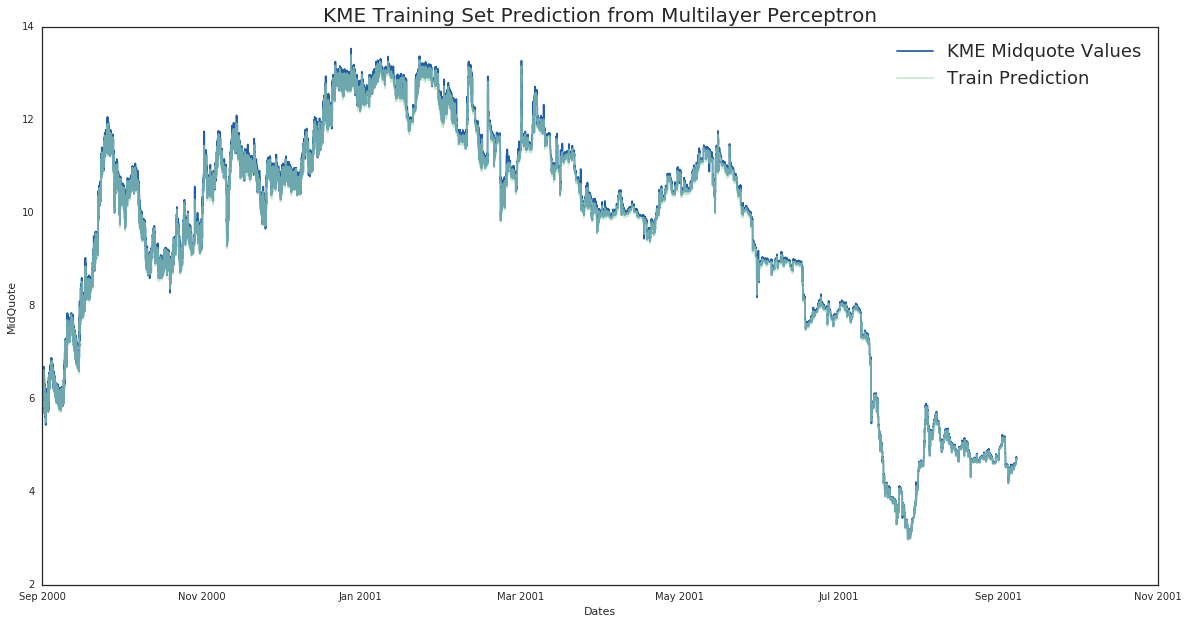

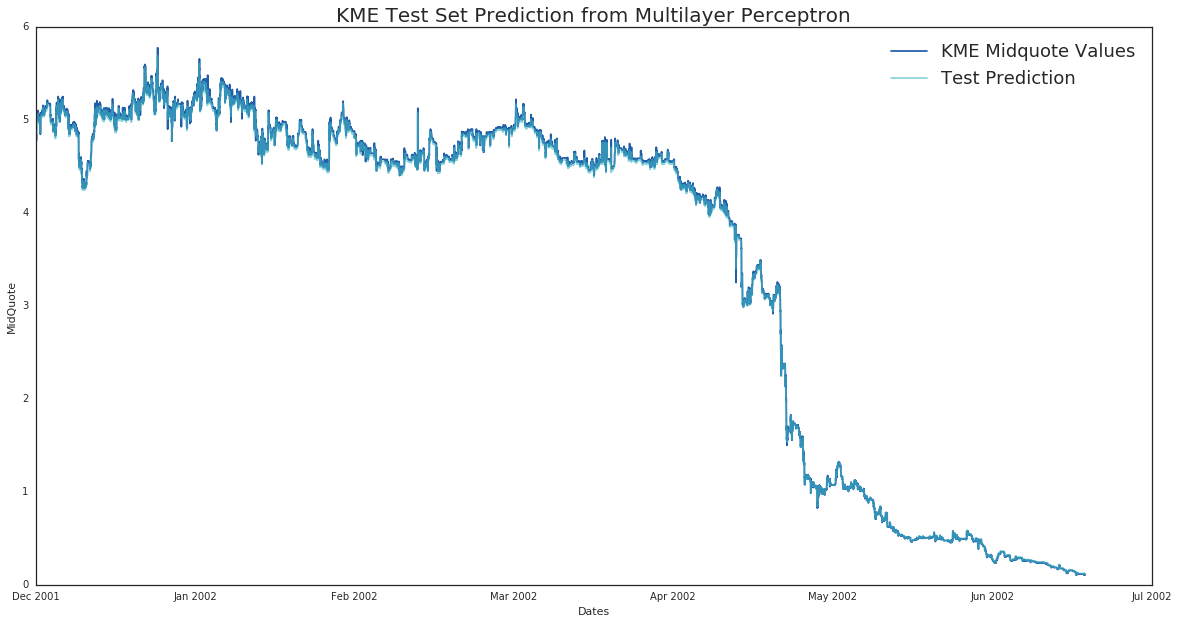

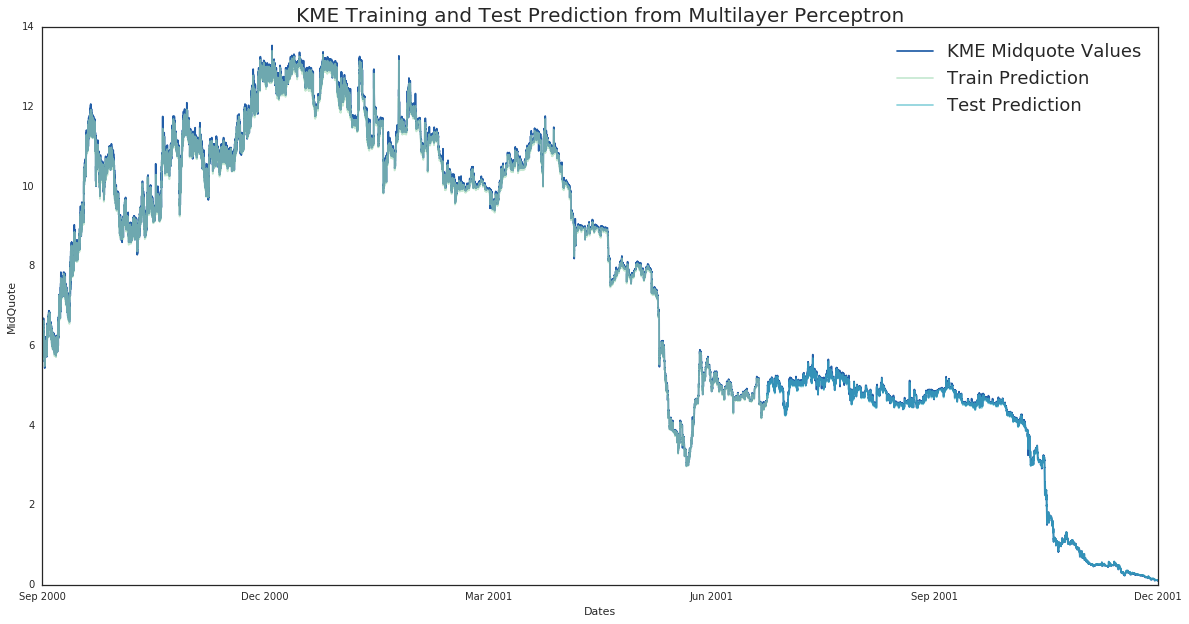

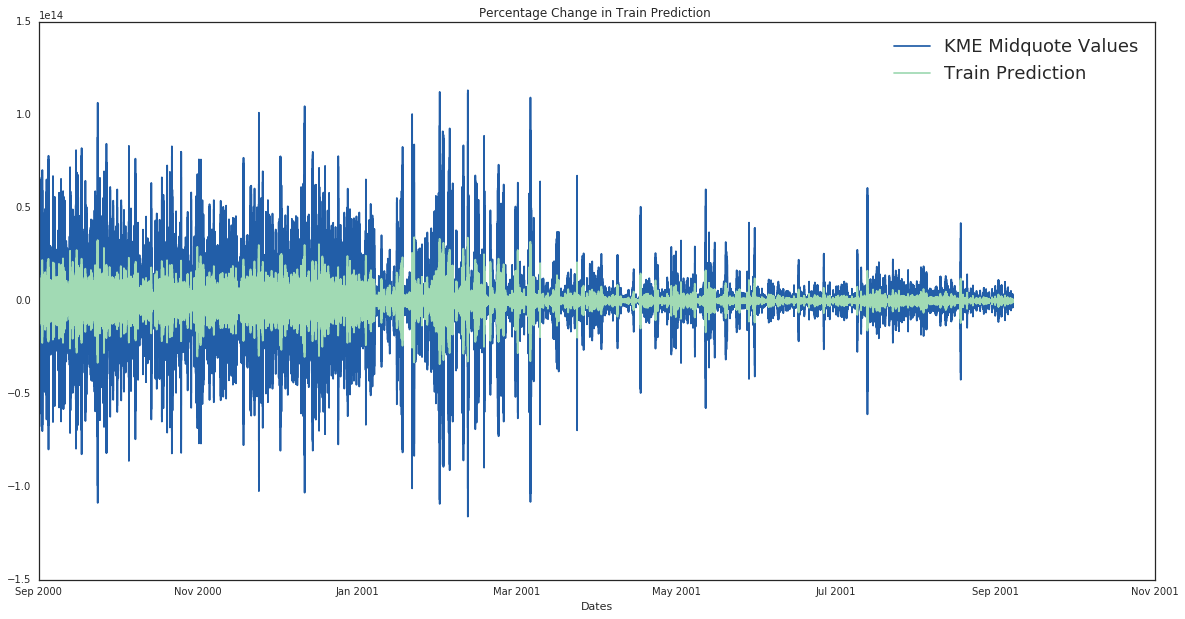

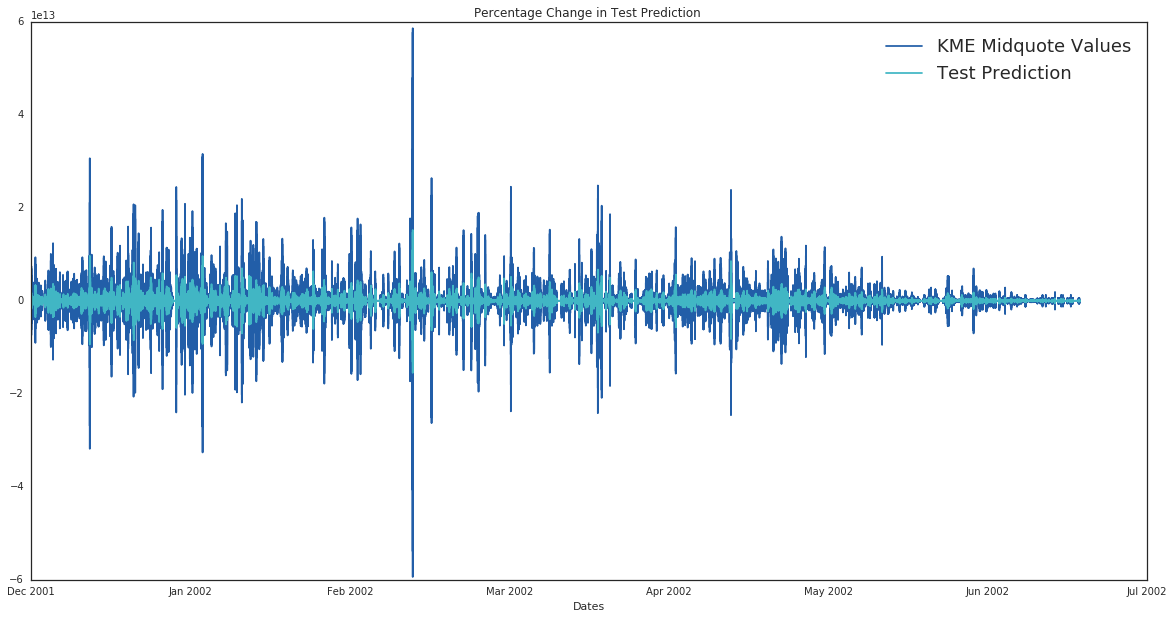

In [367]:
consolidate_learning(16,0,.65,.35,df_KME,10,'KME Training Set Prediction from Multilayer Perceptron','KME Test Set Prediction from Multilayer Perceptron')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/20
9s - loss: 0.2500
Epoch 2/20
9s - loss: 0.0055
Epoch 3/20
9s - loss: 0.0051
Epoch 4/20
9s - loss: 0.0049
Epoch 5/20
9s - loss: 0.0047
Epoch 6/20
9s - loss: 0.0045
Epoch 7/20
9s - loss: 0.0044
Epoch 8/20
9s - loss: 0.0043
Epoch 9/20
9s - loss: 0.0043
Epoch 10/20
9s - loss: 0.0043
Epoch 11/20
9s - loss: 0.0043
Epoch 12/20
9s - loss: 0.0042
Epoch 13/20
9s - loss: 0.0042
Epoch 14/20
9s - loss: 0.0041
Epoch 15/20
9s - loss: 0.0041
Epoch 16/20
9s - loss: 0.0041
Epoch 17/20
9s - loss: 0.0041
Epoch 18/20
9s - loss: 0.0041
Epoch 19/20
9s - loss: 0.0040
Epoch 20/20
9s - loss: 0.0040
Train Score: 0.00440365362902
Test Score: 0.00563585469968
Mean Squared Error of Training =  0.010273679736
Mean Squared Error of Test =  0.00575278136196


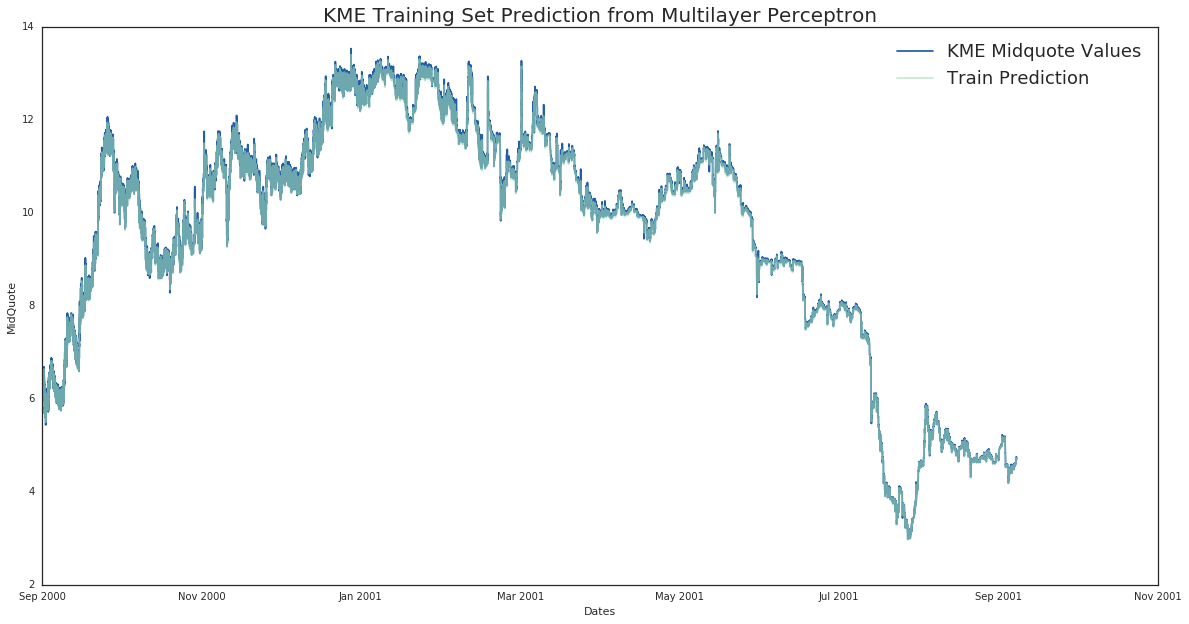

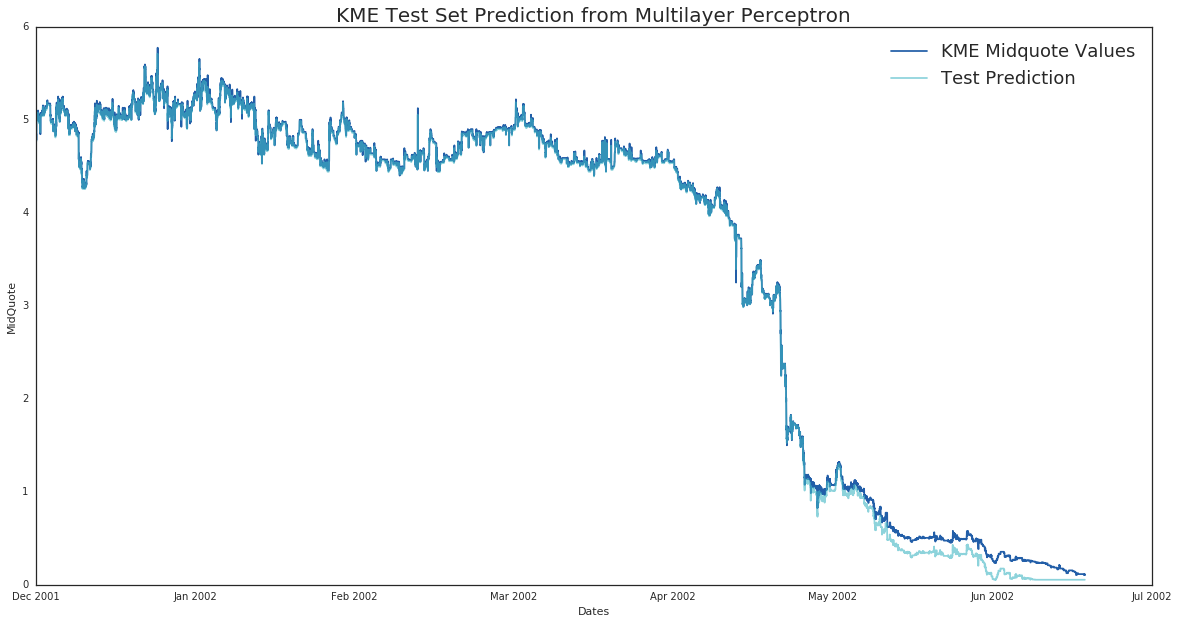

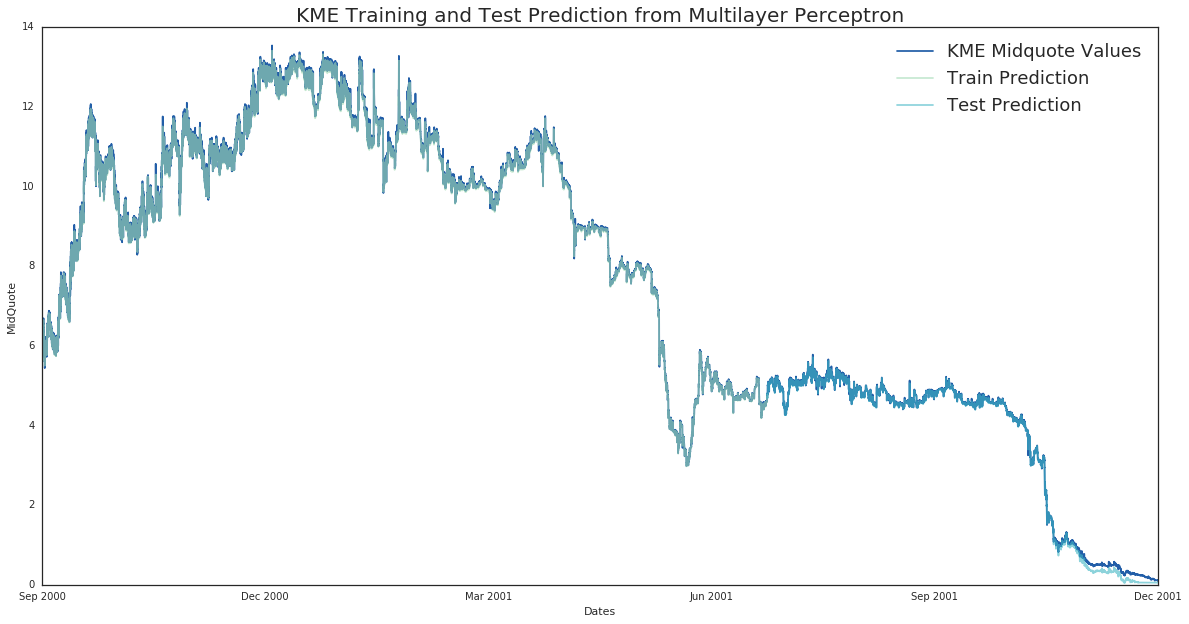

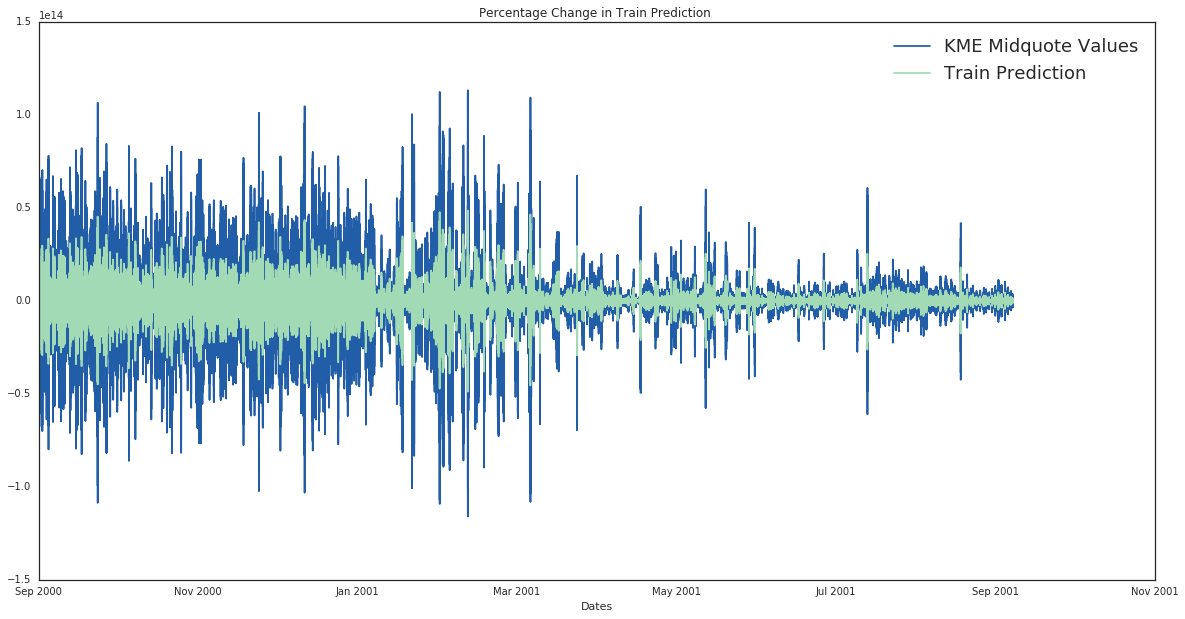

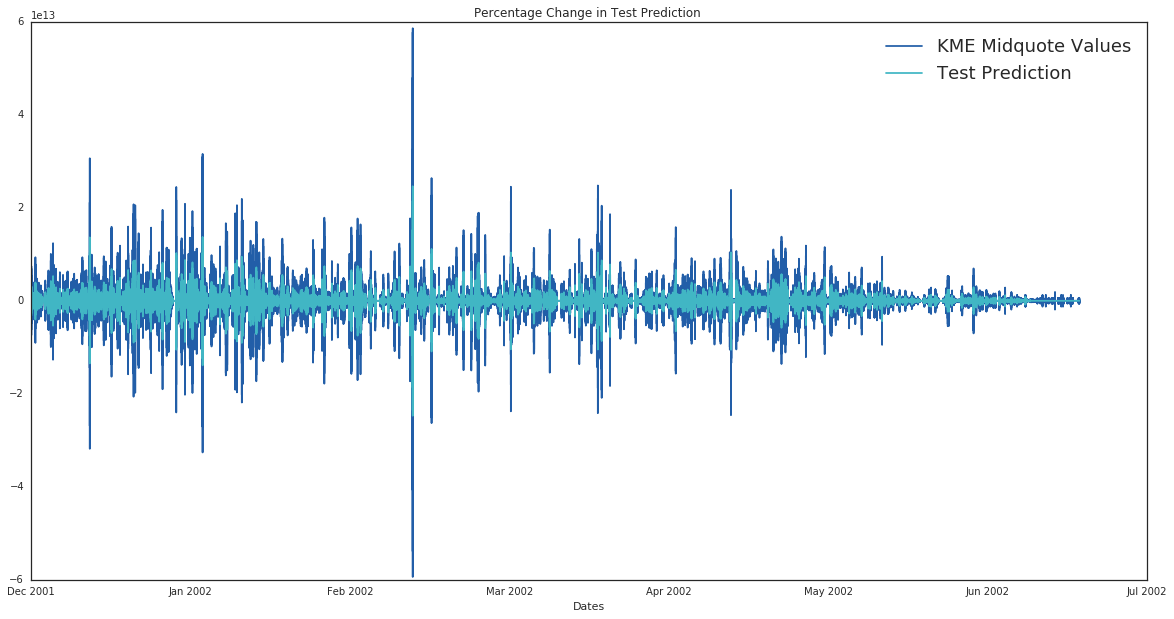

In [365]:
consolidate_learning(16,1,.65,.35,df_KME,10,'KME Training Set Prediction from Multilayer Perceptron','KME Test Set Prediction from Multilayer Perceptron')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/20
10s - loss: 0.0620
Epoch 2/20
10s - loss: 0.0060
Epoch 3/20
10s - loss: 0.0055
Epoch 4/20
10s - loss: 0.0053
Epoch 5/20
11s - loss: 0.0050
Epoch 6/20
11s - loss: 0.0047
Epoch 7/20
10s - loss: 0.0045
Epoch 8/20
10s - loss: 0.0045
Epoch 9/20
11s - loss: 0.0044
Epoch 10/20
11s - loss: 0.0044
Epoch 11/20
11s - loss: 0.0043
Epoch 12/20
10s - loss: 0.0043
Epoch 13/20
10s - loss: 0.0043
Epoch 14/20
10s - loss: 0.0043
Epoch 15/20
10s - loss: 0.0043
Epoch 16/20
10s - loss: 0.0042
Epoch 17/20
10s - loss: 0.0042
Epoch 18/20
10s - loss: 0.0042
Epoch 19/20
10s - loss: 0.0042
Epoch 20/20
10s - loss: 0.0041
Train Score: 0.00320127937628
Test Score: 0.0043091359383
Mean Squared Error of Training =  0.00896512464735
Mean Squared Error of Test =  0.00443209335173


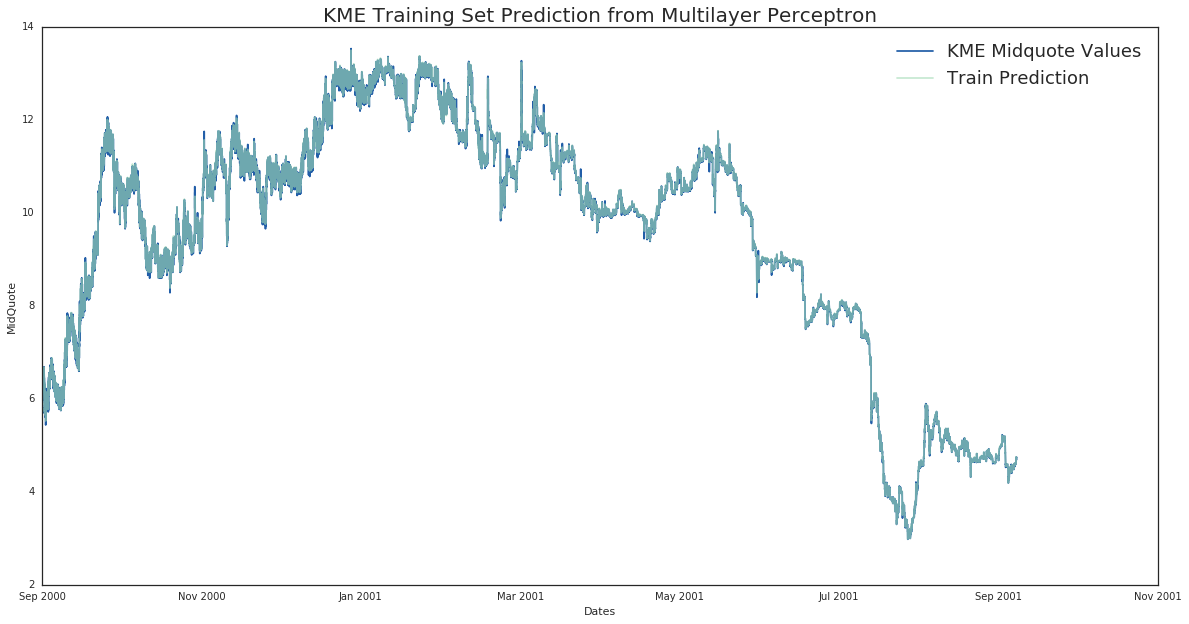

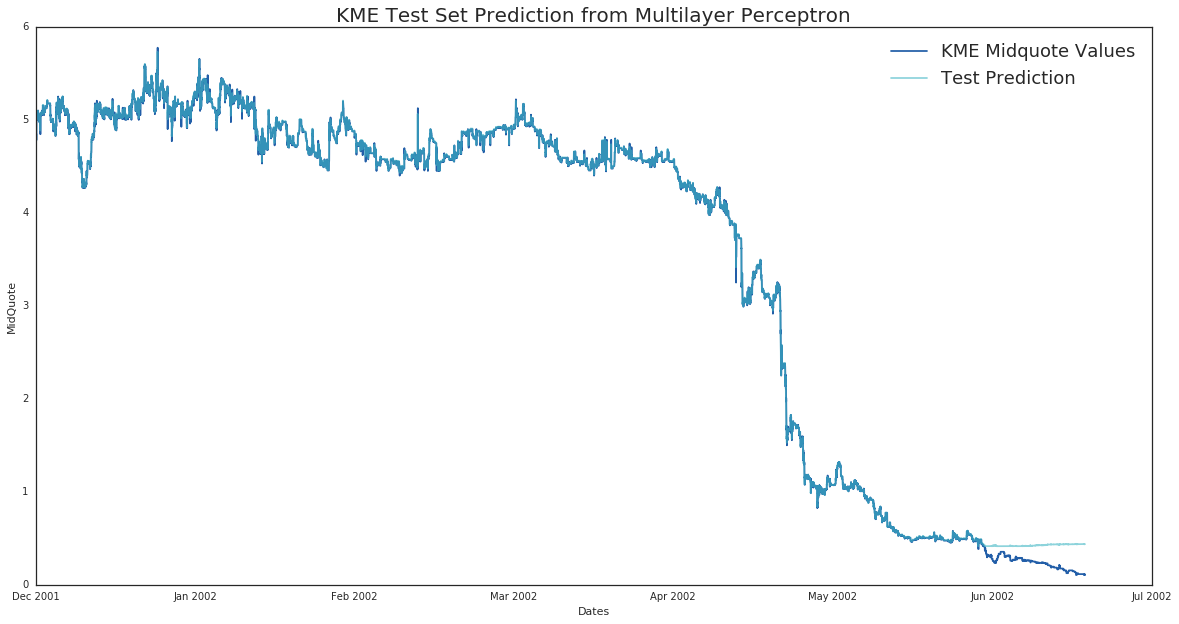

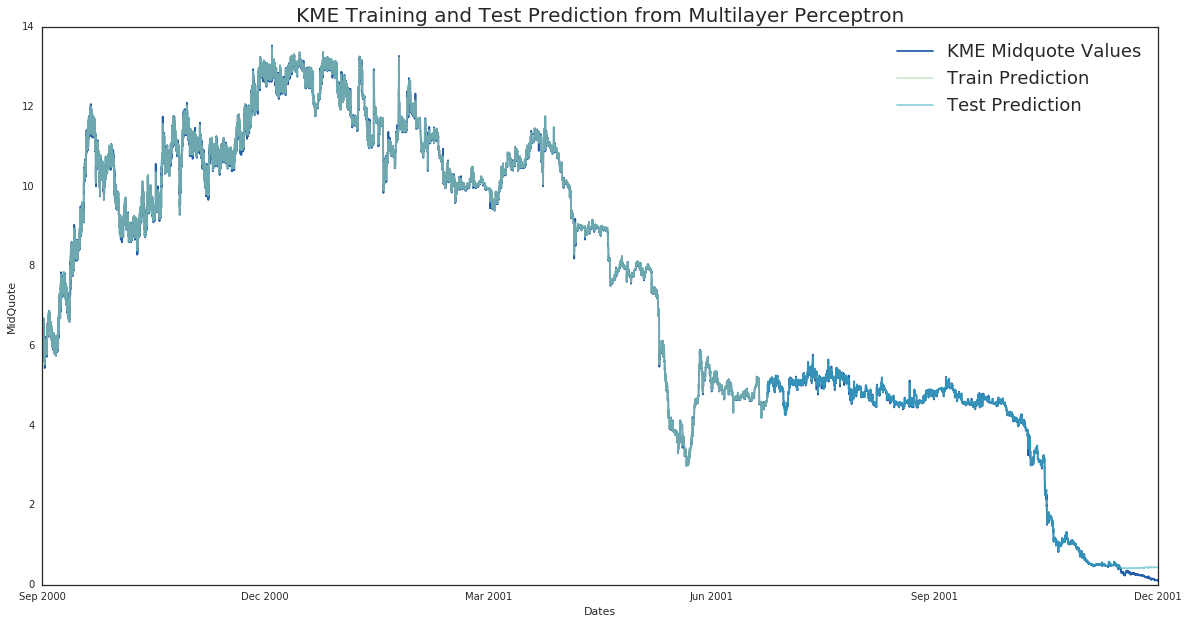

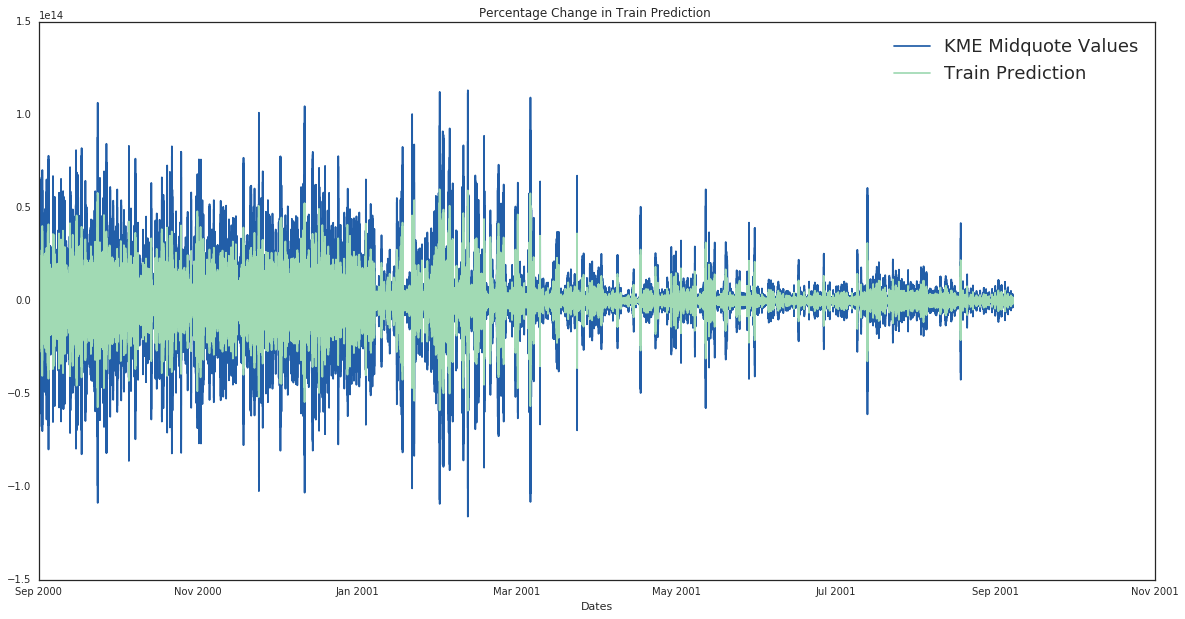

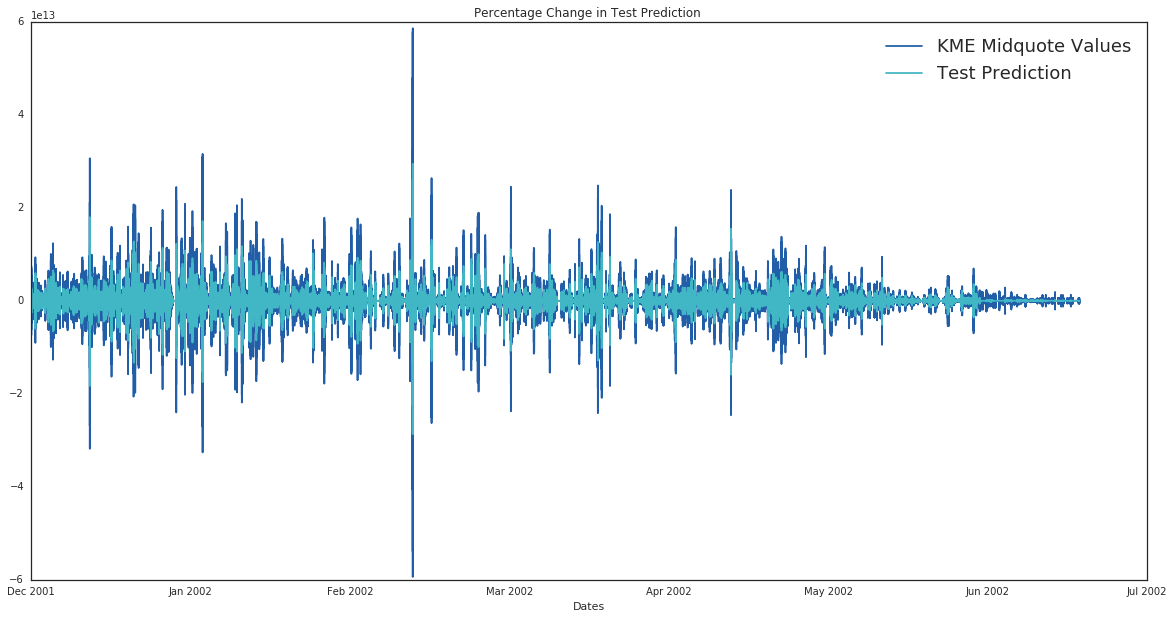

In [340]:
consolidate_learning(16,2,.65,.35,df_KME,10,'KME Training Set Prediction from Multilayer Perceptron','KME Test Set Prediction from Multilayer Perceptron')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/20
11s - loss: 0.0728
Epoch 2/20
12s - loss: 0.0118
Epoch 3/20
12s - loss: 0.0102
Epoch 4/20
12s - loss: 0.0094
Epoch 5/20
13s - loss: 0.0086
Epoch 6/20
13s - loss: 0.0081
Epoch 7/20
13s - loss: 0.0076
Epoch 8/20
13s - loss: 0.0073
Epoch 9/20
13s - loss: 0.0069
Epoch 10/20
13s - loss: 0.0067
Epoch 11/20
13s - loss: 0.0065
Epoch 12/20
14s - loss: 0.0063
Epoch 13/20
14s - loss: 0.0062
Epoch 14/20
14s - loss: 0.0060
Epoch 15/20
13s - loss: 0.0060
Epoch 16/20
14s - loss: 0.0058
Epoch 17/20
14s - loss: 0.0057
Epoch 18/20
14s - loss: 0.0056
Epoch 19/20
14s - loss: 0.0056
Epoch 20/20
14s - loss: 0.0055
Train Score: 0.00467338790759
Test Score: 0.000394619438351
Mean Squared Error of Training =  0.0424847103314
Mean Squared Error of Test =  0.000500693180888


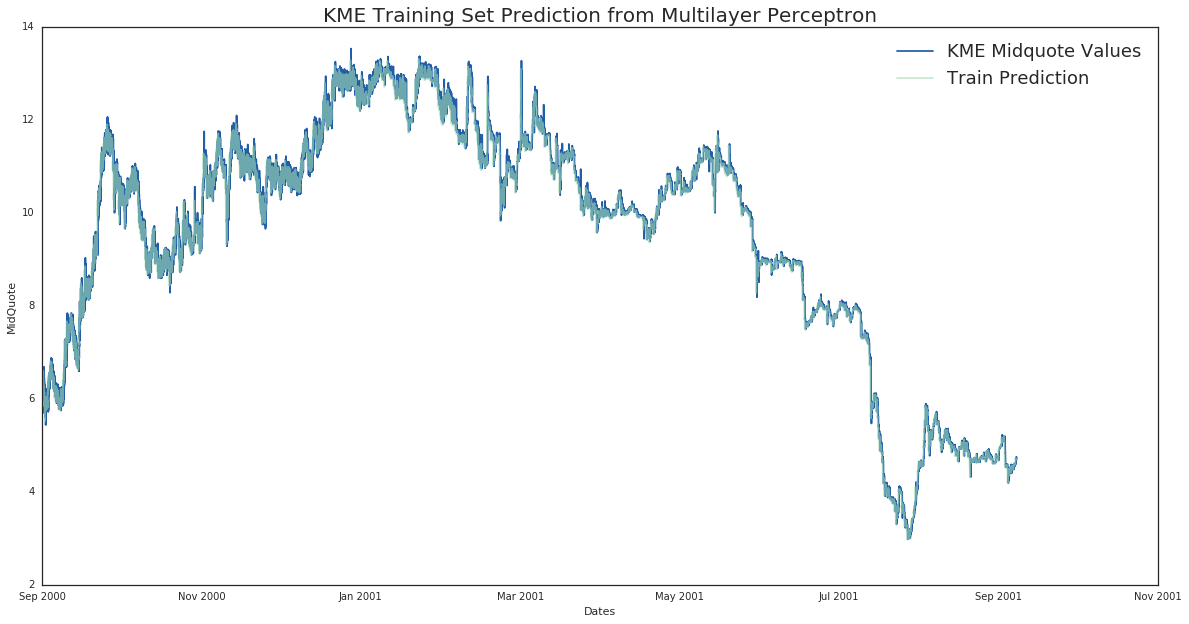

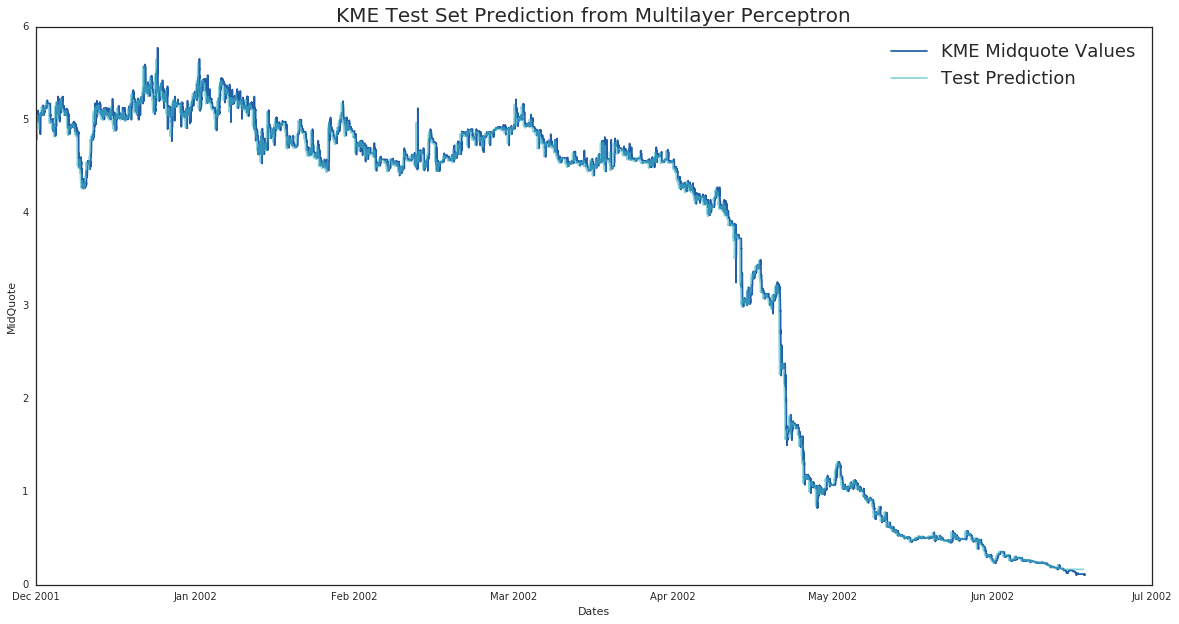

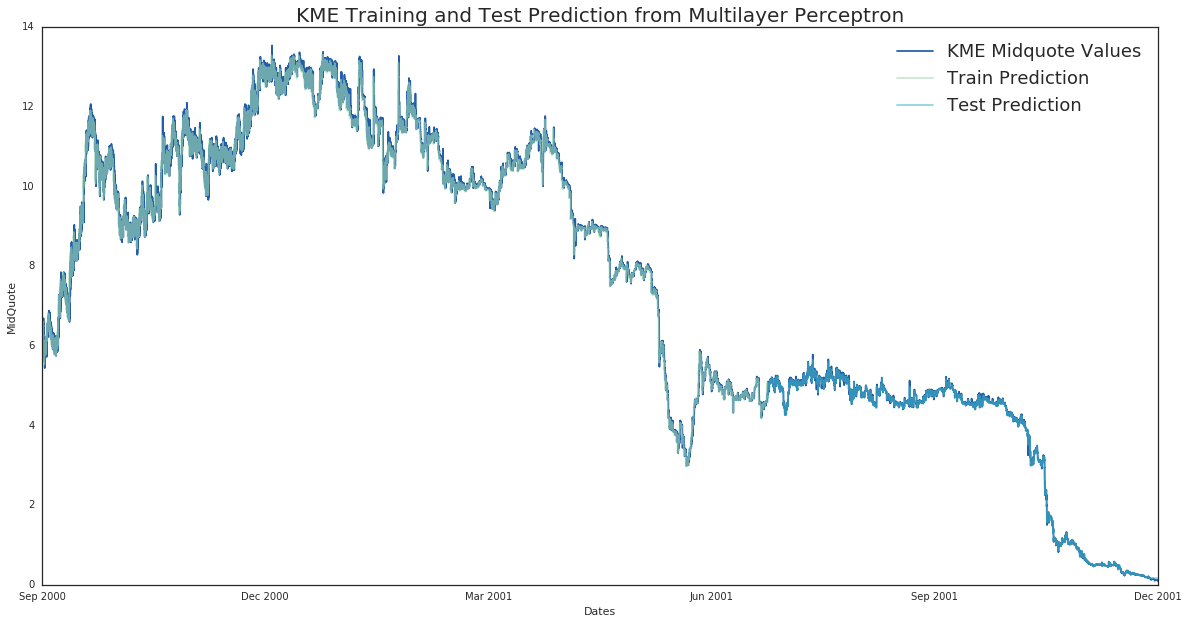

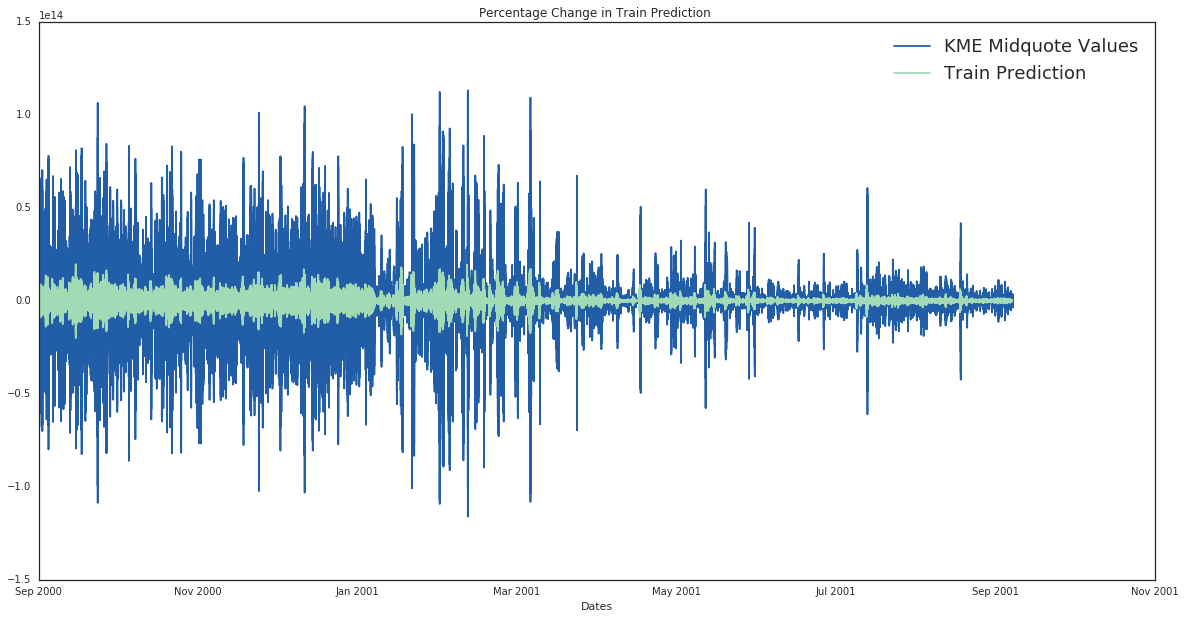

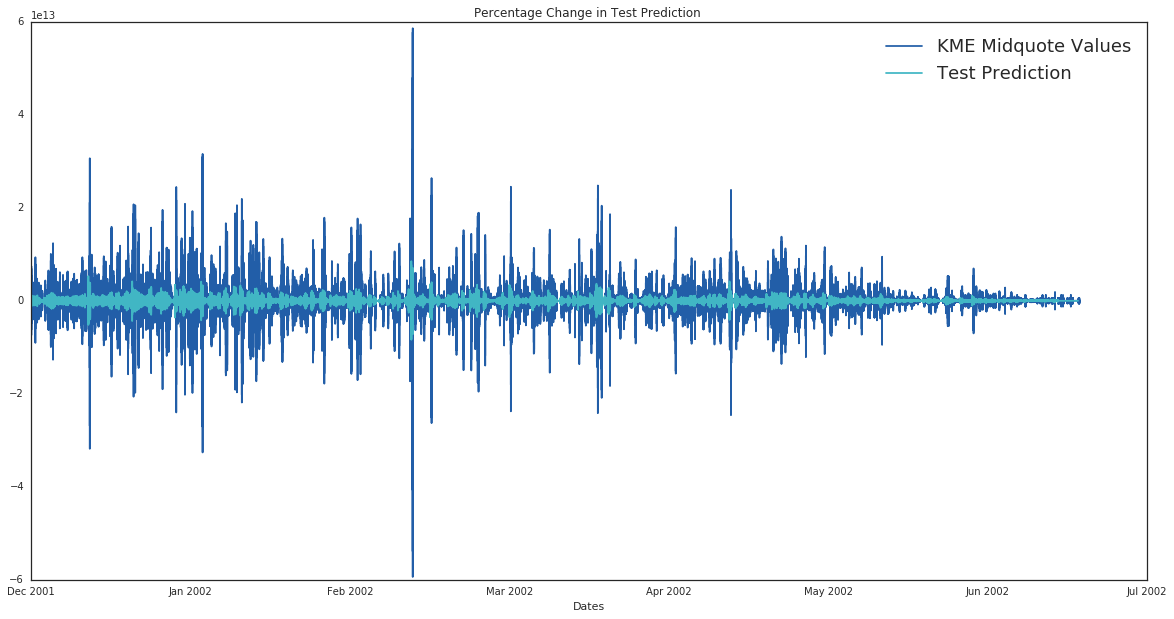

In [341]:
consolidate_learning(16,2,.65,.35,df_KME,100,'KME Training Set Prediction from Multilayer Perceptron','KME Test Set Prediction from Multilayer Perceptron')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/20
26s - loss: 0.0569
Epoch 2/20
29s - loss: 0.0241
Epoch 3/20
29s - loss: 0.0201
Epoch 4/20
35s - loss: 0.0178
Epoch 5/20
41s - loss: 0.0160
Epoch 6/20
41s - loss: 0.0150
Epoch 7/20
41s - loss: 0.0142
Epoch 8/20
41s - loss: 0.0133
Epoch 9/20
41s - loss: 0.0130
Epoch 10/20
42s - loss: 0.0123
Epoch 11/20
42s - loss: 0.0118
Epoch 12/20
42s - loss: 0.0116
Epoch 13/20
41s - loss: 0.0115
Epoch 14/20
41s - loss: 0.0111
Epoch 15/20
41s - loss: 0.0111
Epoch 16/20
41s - loss: 0.0108
Epoch 17/20
41s - loss: 0.0106
Epoch 18/20
40s - loss: 0.0104
Epoch 19/20
41s - loss: 0.0104
Epoch 20/20
42s - loss: 0.0101
Train Score: 0.00677010296607
Test Score: 0.000748885668976
Mean Squared Error of Training =  0.363470126085
Mean Squared Error of Test =  0.000839856101171


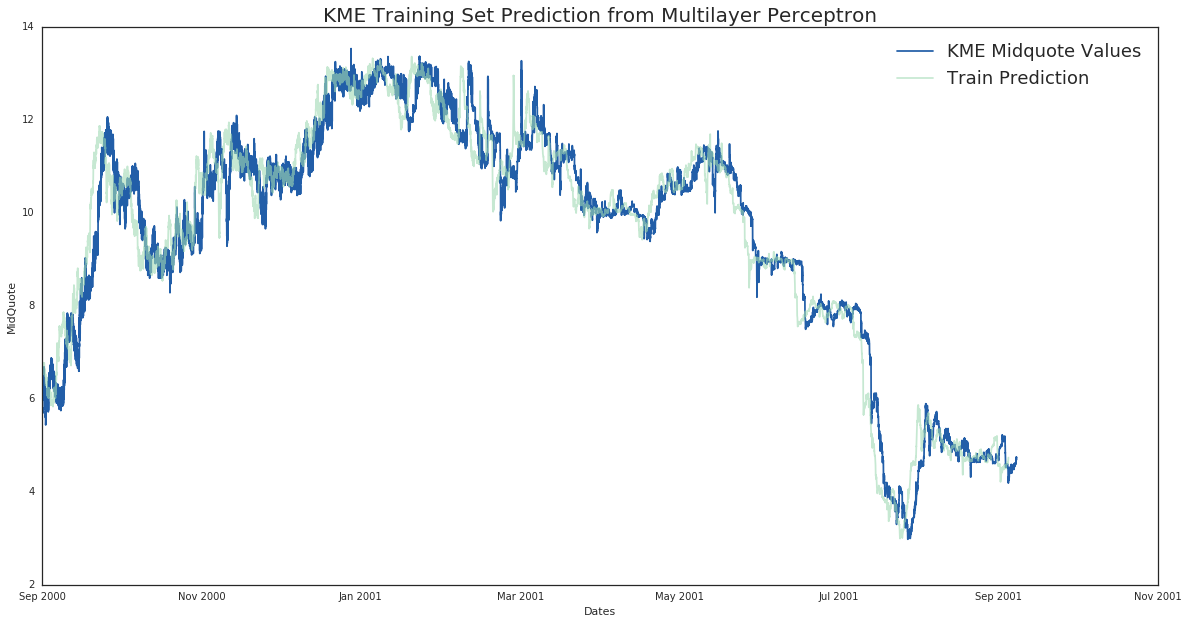

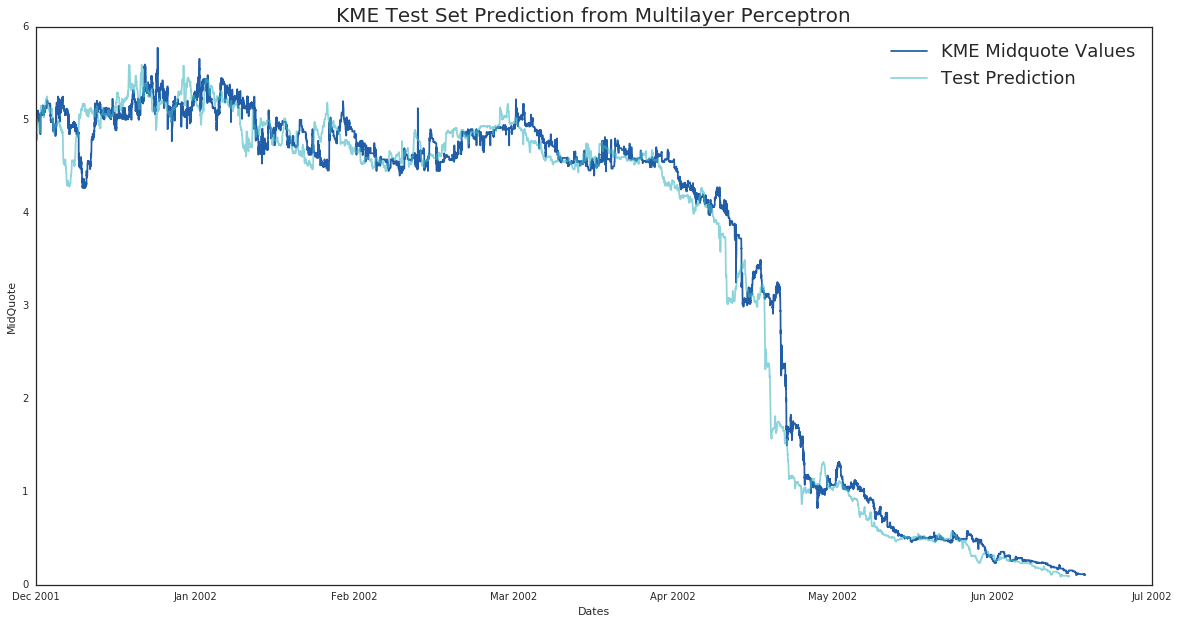

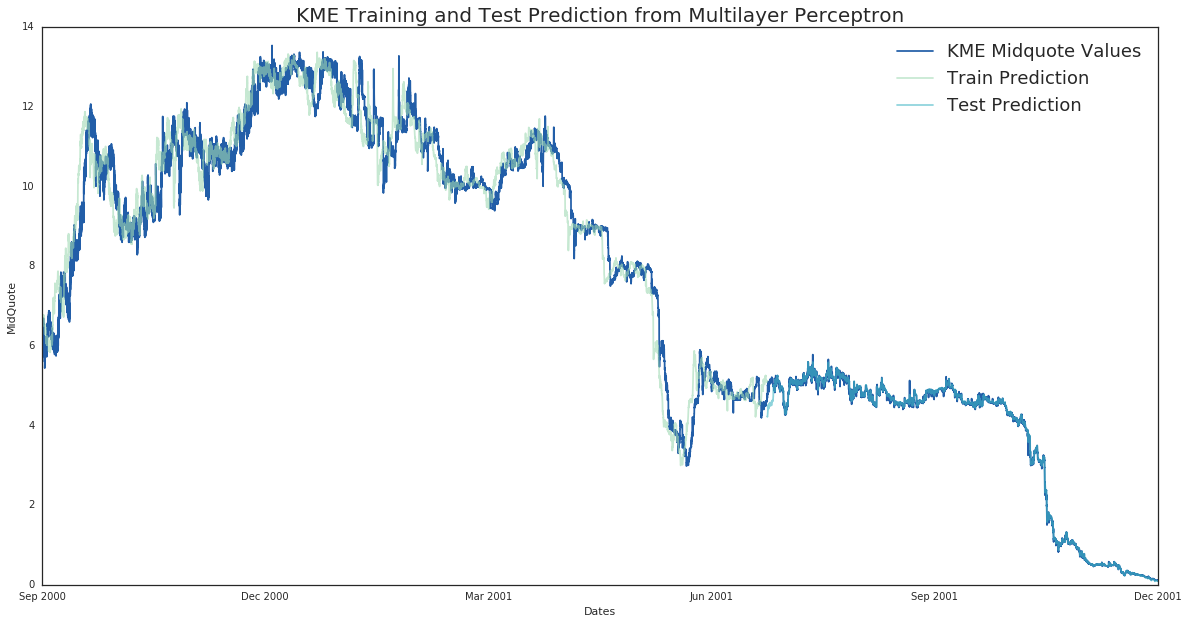

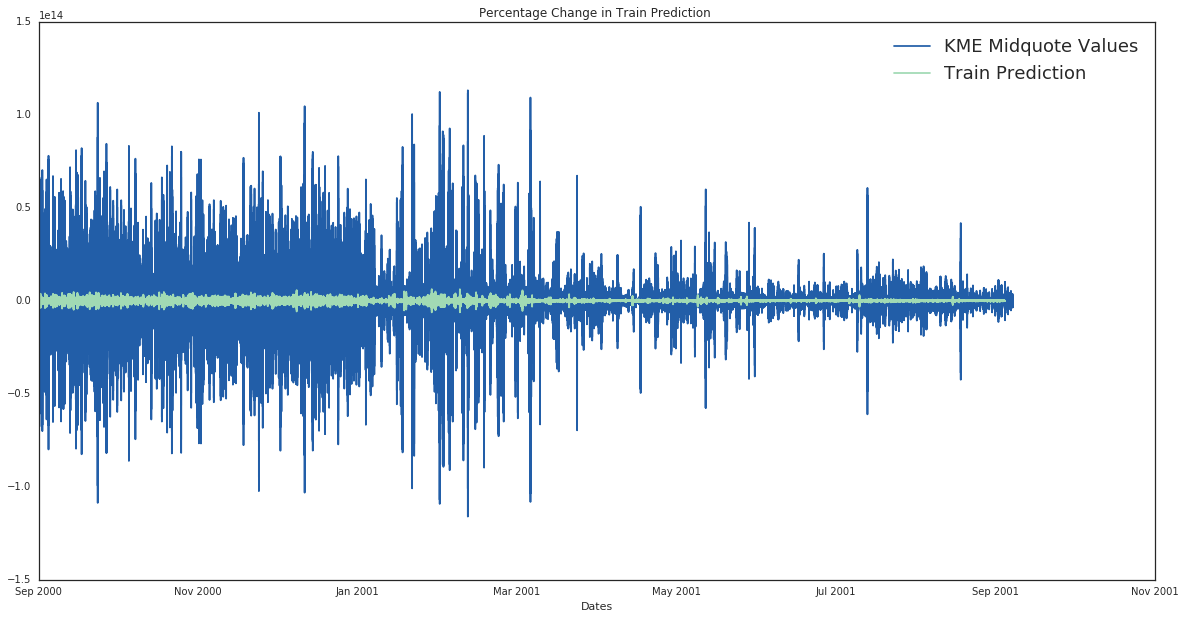

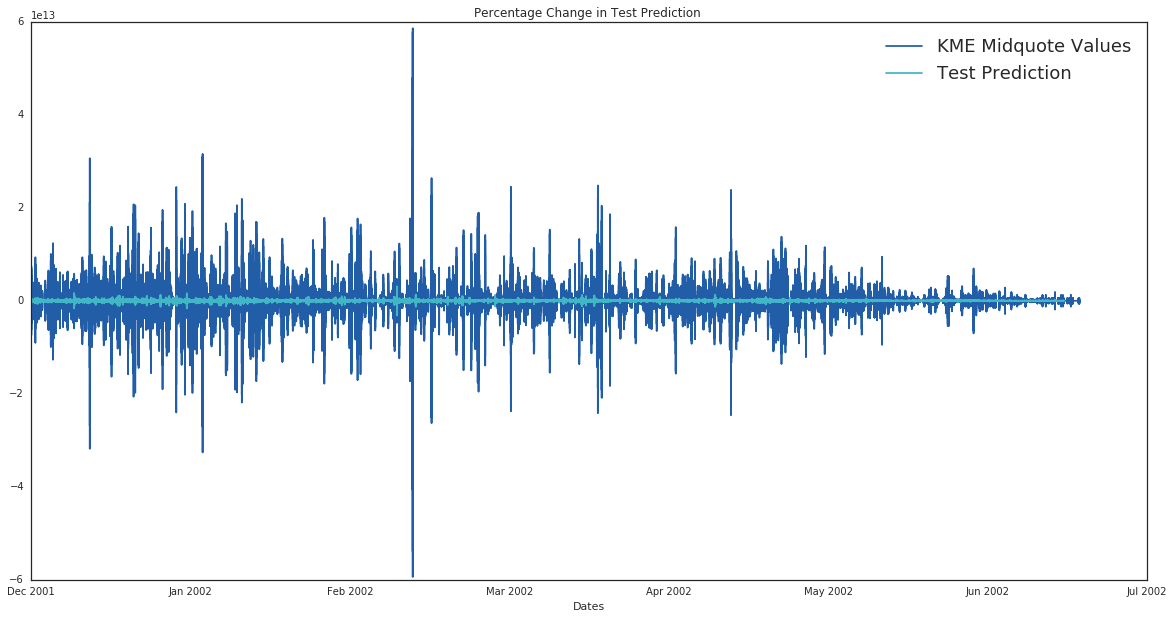

In [342]:
consolidate_learning(16,2,.65,.35,df_KME,1000,'KME Training Set Prediction from Multilayer Perceptron','KME Test Set Prediction from Multilayer Perceptron')

## Keras LSTM Model

In [345]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [416]:
def consolidate_learning_lstm(initial_neurons,hidden_layers,train_percent,test_percent,data_df,look_back,title_train,title_test):
    np.random.seed(7)
    scalar = MinMaxScaler(feature_range=(0, 1))
    normalized_data = data_df['mquote'].values.reshape(len(data_df['mquote'].values),1)
    normalized_data = scalar.fit_transform(normalized_data)
    train_size=math.floor(len(normalized_data)*train_percent)
    test_size = len(normalized_data)-train_size
    train_values = normalized_data[0:train_size]
    test_values = normalized_data[train_size:train_size+test_size]
    train_X,train_Y = create_training_set(train_values,look_back=look_back)
    test_X,test_Y = create_training_set(test_values,look_back=look_back)
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
    model_LSTM= Sequential()
    model_LSTM.add(LSTM(initial_neurons, input_dim=look_back))
    for x in range(hidden_layers):
        num =1
        if(math.floor(hidden_layers/2)==0):
            num =1
        else:
            num = math.floor(hidden_layers/2)
            
        model_LSTM.add(Dense(initial_neurons/num,activation='relu'))
        initial_neurons = initial_neurons/hidden_layers
    model_LSTM.add(Dense(1,activation='sigmoid'))
    model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
    model_LSTM.fit(train_X, train_Y, nb_epoch=50, batch_size=5, verbose=2)
    train_evaluation  = model_LSTM.evaluate(train_X,train_Y,batch_size=5,verbose=0)
    test_evaluation = model_LSTM.evaluate(test_X,test_Y,batch_size=5,verbose=0)
    train_LSTM_predict = model_LSTM.predict(train_X)
    test_LSTM_predict = model_LSTM.predict(test_X)
    train_LSTM_predict = scalar.inverse_transform(train_LSTM_predict)
    train_Y = scalar.inverse_transform(train_Y.reshape(-1, 1))
    test_LSTM_predict = scalar.inverse_transform(test_LSTM_predict)
    test_Y = scalar.inverse_transform(test_Y.reshape(-1, 1))
    
    train_predict_plot = np.empty_like(normalized_data)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_LSTM_predict)+look_back, :] = train_LSTM_predict
    test_predict_plot = np.empty_like(normalized_data)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_LSTM_predict)+(look_back*2)+1:len(normalized_data)-1, :] = test_LSTM_predict
    print("Train Score:",train_evaluation)
    print("Test Score:", test_evaluation)
    train_LSTM_predict_mse = mean_squared_error(data_df['mquote'].values[0:len(train_LSTM_predict)],train_predict_plot[~np.isnan(train_predict_plot)])
    test_LSTM_predict_mse = mean_squared_error(data_df['mquote'].values[-len(test_LSTM_predict):],test_predict_plot[~np.isnan(test_predict_plot)])
    print("Training Mean Squared Error",train_LSTM_predict_mse)
    print("Testing Mean Squared Error",test_LSTM_predict_mse)
    graphing_wrapper_LSTM(dates_df_fromdf_2(data_df),train_size,test_size,train_predict_plot,test_predict_plot,data_df,title_train,title_test)

In [417]:
def graphing_wrapper_LSTM(dates,len_test,len_train,train,test,data_df,title_test,title_train):
    
    
    xrand = np.linspace(0,10000,len(data_df['mquote'].values))
    
    fig_MLP3, ax_MLP3 = plt.subplots(figsize=(20,10))
    ax_MLP3.plot(xrand,data_df['mquote'].values,color='#225ea8',label='KME Midquote Values')
    ax_MLP3.plot(xrand[0:train_size],np.concatenate((train,test))[0:(train_size)],alpha=0.6,color='#a1dab4',label='Train Prediction')
    #ax_MLP3.plot(data_df['mquote'].values[-(test_size):],color='#225ea8',label='KME Midquote Values')
    ax_MLP3.plot(xrand[-test_size:],np.concatenate((train,test))[-(test_size):],color='#41b6c4',alpha=0.6,label='Test Prediction')
    ax_MLP3.set_title('KME Training and Test Prediction from Long Short Term Memory',size=20)
    ax_MLP3.set_xlabel('Dates')
    ax_MLP3.set_ylabel('MidQuote')
    ax_MLP3.legend(prop={'size':18})
    ax_MLP3.set_xticklabels(['Sep 2000','Dec 2000','Mar 2001','Jun 2001','Sep 2001','Dec 2001','Mar 2002','Jun 2002'])

    
    ''' 
    fig_MLP4, ax_MLP4 = plt.subplots(figsize=(20,10))
    ax_MLP4.plot(np.diff(data_df['mquote'].values[0:train_size],n=50),color='#225ea8',label='KME Midquote Values')
    ax_MLP4.plot(np.diff(train,n=50),color='#a1dab4',label='Train Prediction')
    ax_MLP4.set_xticklabels(['Sep 2000','Nov 2000','Jan 2001','Mar 2001','May 2001','Jul 2001','Sep 2001','Nov 2001'])
    ax_MLP4.set_title('Percentage Change in Train Prediction ')
    ax_MLP4.set_xlabel('Dates')
    ax_MLP4.legend(prop={'size':18})
    train_mse = mean_squared_error(data_df['mquote'].values[0:len(train)],train)
    print("Mean Squared Error of Training = ", train_mse)
    
    
    fig_MLP5, ax_MLP5 = plt.subplots(figsize=(20,10))
    ax_MLP5.plot(np.diff(data_df['mquote'].values[-len(test_MLP_predict):],n=50),color='#225ea8',label='KME Midquote Values')
    ax_MLP5.plot(np.diff(test,n=50),color='#41b6c4',label='Test Prediction')
    ax_MLP5.set_xticklabels(['Dec 2001','Jan 2002','Feb 2002','Mar 2002','Apr 2002','May 2002','Jun 2002','Jul 2002'])
    ax_MLP5.set_title('Percentage Change in Test Prediction ')
    ax_MLP5.set_xlabel('Dates')
    ax_MLP5.legend(prop={'size':18})
    test_mse = mean_squared_error(data_df['mquote'].values[-len(test):],test)
    print("Mean Squared Error of Test = ", test_mse) '''


/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/50
34s - loss: 4.2878e-04
Epoch 2/50
33s - loss: 5.0874e-05
Epoch 3/50
34s - loss: 4.1970e-05
Epoch 4/50
34s - loss: 3.5056e-05
Epoch 5/50
34s - loss: 3.2327e-05
Epoch 6/50
33s - loss: 3.0177e-05
Epoch 7/50
34s - loss: 2.8624e-05
Epoch 8/50
34s - loss: 2.7796e-05
Epoch 9/50
36s - loss: 2.6733e-05
Epoch 10/50
34s - loss: 2.6499e-05
Epoch 11/50
33s - loss: 2.5663e-05
Epoch 12/50
35s - loss: 2.5011e-05
Epoch 13/50
33s - loss: 2.4878e-05
Epoch 14/50
34s - loss: 2.4193e-05
Epoch 15/50
33s - loss: 2.3983e-05
Epoch 16/50
34s - loss: 2.3700e-05
Epoch 17/50
34s - loss: 2.3668e-05
Epoch 18/50
33s - loss: 2.3471e-05
Epoch 19/50
34s - loss: 2.3290e-05
Epoch 20/50
34s - loss: 2.3074e-05
Epoch 21/50
33s - loss: 2.2965e-05
Epoch 22/50
34s - loss: 2.2994e-05
Epoch 23/50
35s - loss: 2.2990e-05
Epoch 24/50
35s - loss: 2.2633e-05
Epoch 25/50
35s - loss: 2.2455e-05
Epoch 26/50
34s - loss: 2.2418e-05
Epoch 27/50
35s - loss: 2.2335e-05
Epoch 28/50
34s - loss: 2.2208e-05
Epoch 29/50
33s - loss: 2.218

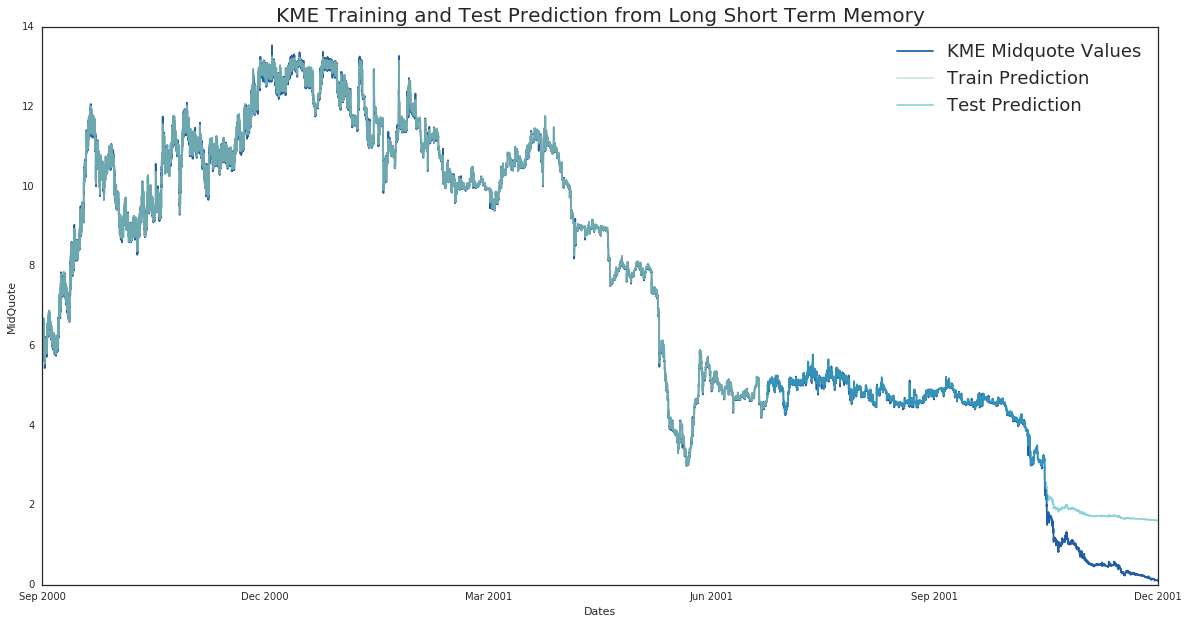

In [418]:
consolidate_learning_lstm(16,2,.65,.35,df_KME,10,'KME Training Set Prediction from Longest Short Term Memory','KME Test Set Prediction from Longest Short Term Memory')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/50
37s - loss: 3.5996e-04
Epoch 2/50
37s - loss: 8.2509e-05
Epoch 3/50
37s - loss: 6.9137e-05
Epoch 4/50
38s - loss: 6.0672e-05
Epoch 5/50
40s - loss: 5.2833e-05
Epoch 6/50
39s - loss: 5.0651e-05
Epoch 7/50
39s - loss: 4.7853e-05
Epoch 8/50
40s - loss: 4.4904e-05
Epoch 9/50
39s - loss: 4.3171e-05
Epoch 10/50
40s - loss: 4.1671e-05
Epoch 11/50
40s - loss: 4.0547e-05
Epoch 12/50
40s - loss: 3.9546e-05
Epoch 13/50
40s - loss: 3.9063e-05
Epoch 14/50
40s - loss: 3.8101e-05
Epoch 15/50
40s - loss: 3.7067e-05
Epoch 16/50
40s - loss: 3.6341e-05
Epoch 17/50
39s - loss: 3.5870e-05
Epoch 18/50
40s - loss: 3.5360e-05
Epoch 19/50
39s - loss: 3.4599e-05
Epoch 20/50
40s - loss: 3.4628e-05
Epoch 21/50
40s - loss: 3.3803e-05
Epoch 22/50
40s - loss: 3.3591e-05
Epoch 23/50
40s - loss: 3.2926e-05
Epoch 24/50
40s - loss: 3.2547e-05
Epoch 25/50
41s - loss: 3.2606e-05
Epoch 26/50
39s - loss: 3.2344e-05
Epoch 27/50
39s - loss: 3.1786e-05
Epoch 28/50
39s - loss: 3.1607e-05
Epoch 29/50
39s - loss: 3.091

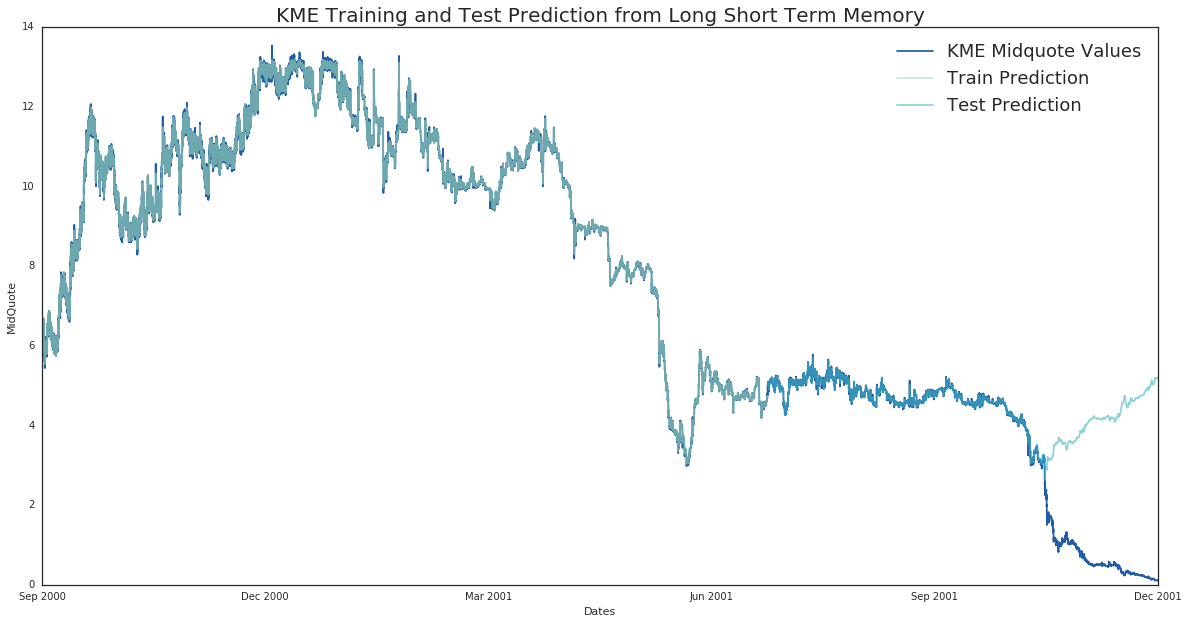

In [419]:
consolidate_learning_lstm(16,2,.65,.35,df_KME,100,'KME Training Set Prediction from Longest Short Term Memory','KME Test Set Prediction from Longest Short Term Memory')

In [ ]:
consolidate_learning_lstm(16,2,.65,.35,df_KME,1000,'KME Training Set Prediction from Longest Short Term Memory','KME Test Set Prediction from Longest Short Term Memory')

/usr/local/lib/python3.5/dist-packages/keras/initializations.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
/usr/local/lib/python3.5/dist-packages/keras/backend/theano_backend.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


Epoch 1/50
